# Modeling

Modeling
In this notebook we
1. Load '/Users/KATMER/Desktop/github/train.csv' which is the output of exploratory data analysis.
2. Apply different model to predict House prices.

## Import Packages

In [164]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 8)
sns.set_palette(palette)

## Load Data

In [165]:
df = pd.read_csv('/Users/KATMER/Desktop/github/train.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In the data, we have 80 features, 1 target. Total 1460 data points.

## Prepare Functions for Plotting

In [167]:
def get_sub_plots(n_total_cols, n_cols, label_font_size = 14, tick_font_size = 13):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows,
                             ncols = n_cols,
                             squeeze = False)
    
    
    fig.set_size_inches(10 * n_cols, 8 * n_rows)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])

    axes = axes.flatten()
    
    for ax in axes:
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)

## Explore Data & Enginer Features

Check the price distribution with and without taking log.

In [168]:
def plot_ori_vs_log_comparison(x, xlabel, n_total_cols = 2, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    style = dict(size = fontsize, color = 'gray')
    
    x = pd.Series(x, name = xlabel)
    log_x = pd.Series(np.log(x), name = 'Taking log on ' + xlabel)

    sns.distplot(x, kde = False, ax = axes[0])
    axes[0].text(350, 250, 'Skew = ' + str(x.skew()), **style)
    axes[0].set_title('Histogram of ' + xlabel, fontsize = fontsize)
    axes[0].set_xlabel(xlabel, fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.distplot(log_x, kde = False, ax = axes[1])
    axes[1].text(7.5, 200, 'Skew = ' + str(log_x.skew()), **style)
    axes[1].set_title('Histogram of ' + xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_xlabel(xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_ylabel('Count', fontsize = fontsize)
    
    fig.tight_layout()    
    plt.show()

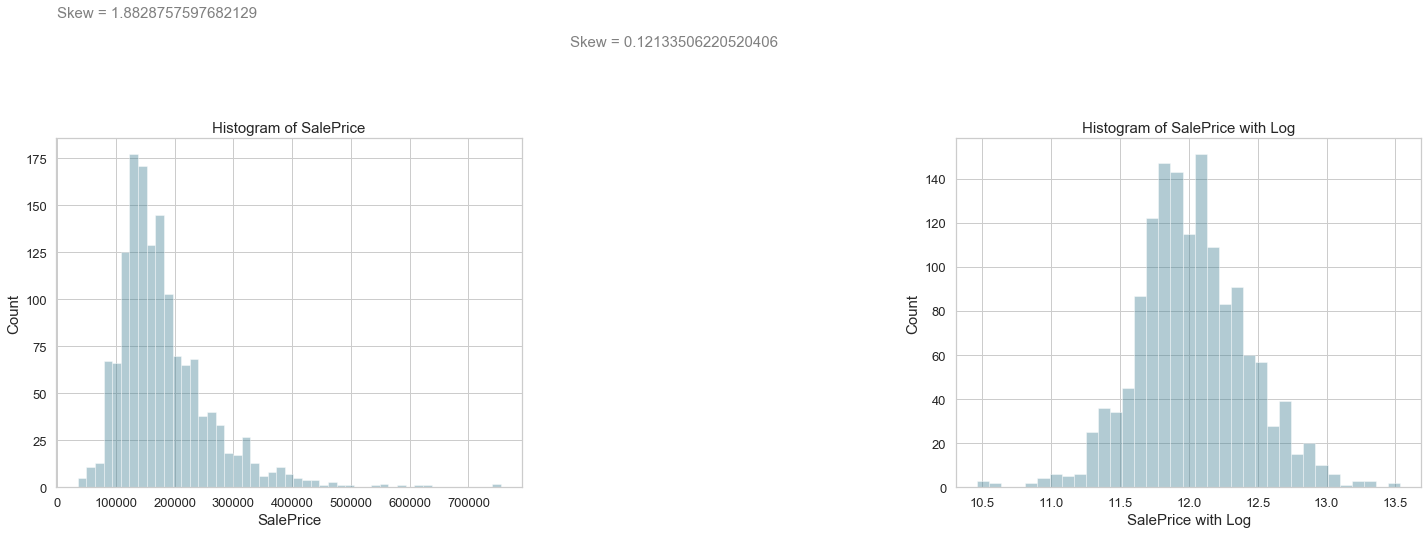

In [169]:
plot_ori_vs_log_comparison(df.SalePrice, 'SalePrice')

Looks like taking log can make it distribute more normally & skew is much improved.

## Prepare functions for Scoring & Reporting

Here we use mean squared error (MSE) & root mean squared error (RMSE) for scoring.

We also plot
1. Histogram of predicted y.
2. Scatter plot of Actual vs. Predicted y
3. Residual plot
4. Histogram of Residuals

In [230]:
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.metrics import mean_squared_error

def plot_summary(y_test, y_pred, n_total_cols = 4, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    
    sns.distplot(y_pred, kde = False, ax = axes[0])
    axes[0].set_title('Histogram of predicted y', fontsize = fontsize)
    axes[0].set_xlabel('Pridected y', fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.regplot(y_test, y_pred, fit_reg = False, ax = axes[1])
    axes[1].set_title('Actual y vs. Predicted y', fontsize = fontsize)
    axes[1].set_xlabel('Actual y', fontsize = fontsize)
    axes[1].set_ylabel('Predicted y', fontsize = fontsize)
    
    sns.regplot(y_pred, y_test - y_pred, fit_reg = False, ax = axes[2])
    axes[2].set_title('Residual Plot', fontsize = fontsize)
    axes[2].set_xlabel('Predicted y', fontsize = fontsize)
    axes[2].set_ylabel('Residuals', fontsize = fontsize)
    
    sns.distplot(y_test - y_pred, kde = False, ax = axes[3])
    axes[3].set_title('Histogram of Residuals', fontsize = fontsize)
    axes[3].set_xlabel('Residuals', fontsize = fontsize)
    axes[3].set_ylabel('Count', fontsize = fontsize)
        
    fig.tight_layout()    
    plt.show()
    
def score_and_plot(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    
    print ('    MSE is: ', mse)
    print ('    RMSE is: ', rmse)

    plot_summary(y_test, y_pred)
    
    return rmse

## Prepare Functions for Modeling

### We will first try the following models:
1. K-Nearest Neighbors
2. Linear Regression
3. Ridge Regression
4. Lasso Regression
5. Random Forest

### Train-Test-Split, Cross-Validation & Standardization
We also use train_test_split to do train-test split, GridSearchCV to do cross-validation & use StandardScaler to standardize the data.

By the way, as in previous plot we can see that taking log can make the target distribute more normally, we add one more argument, take log (or not), to check if it can give better results.

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

Models = ['KNN', 'Linear', 'Ridge', 'Lasso', 'RandomForest']
Linear_Models = ['Linear', 'Ridge', 'Lasso']

def model(model_mode, X, y, take_log):
    if model_mode not in Models:
        print('Mode not defined')
        return
    
    if take_log:
        y = np.log(y)

    steps = [('scaler', StandardScaler())]
    
    if model_mode == 'KNN':
        steps += [('knn', KNeighborsRegressor())]
        param_grid = {'knn__n_neighbors': np.arange(1, 50)}
    elif model_mode == 'Linear':
        steps += [('lm', LinearRegression())]  
        param_grid = {}          
    elif model_mode == 'Ridge':
        steps += [('ridge', Ridge())]
        param_grid = {'ridge__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'Lasso':
        steps = [('lasso', Lasso(max_iter = 10000))]
        param_grid = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'RandomForest':
        steps = [('rf', RandomForestRegressor(random_state = 42))]
        param_grid = {'rf__n_estimators': np.arange(10, 100, 10),
                      'rf__max_depth' : np.arange(10, 100, 10)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model:', model_mode)
    if take_log:
        print('    Taking log on y')
    else:
        print('    NOT taking log on y')
    print('    Best Params:', cv.best_params_)

    y_pred = cv.predict(X_test)
    
    if take_log:
        rmse = score_and_plot(np.exp(y_test), np.exp(y_pred))
    else:
        rmse = score_and_plot(y_test, y_pred)
        
    return (y_test, y_pred, rmse)

def try_all_models(X, y):
    modelRmse = {}
    for m in Models:
        y_test, y_pred, rmse = model(model_mode = m, X = X, y = y, take_log = False)
        modelRmse[m] = rmse
    
        if m in Linear_Models:
            y_test, y_pred, rmse = model(m, X, y, take_log = True)
            
    return modelRmse


## Define Features & Target
Let's start with the most basic features: OverallQual, GrLivArea, and GarageCars.

In [232]:
def get_X_y(df, features, target):
    X = df[features].values
    y = df[target].values
    return (X, y)

In [233]:
X, y = get_X_y(df, ['OverallQual', 'GrLivArea', 'GarageCars'], 'SalePrice')

## Modeling
And run all the models quickly.

Model: KNN
    NOT taking log on y
    Best Params: {'knn__n_neighbors': 10}
    MSE is:  843226957.8357918
    RMSE is:  29038.370440432634


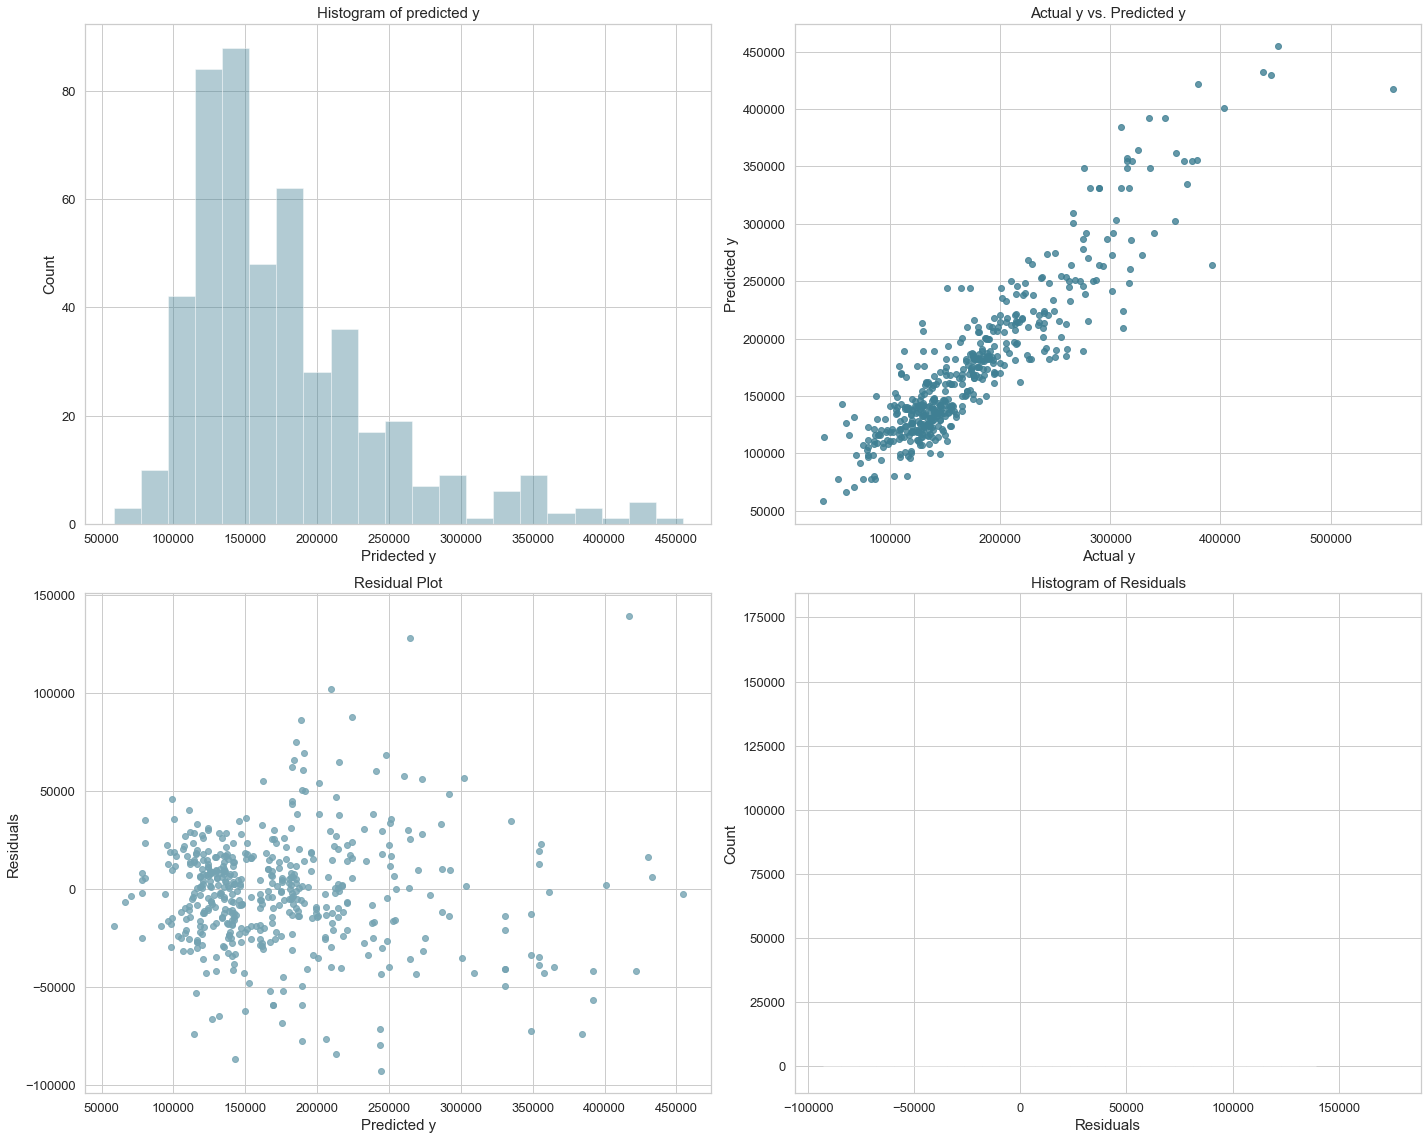

Model: Linear
    NOT taking log on y
    Best Params: {}
    MSE is:  1139401355.329883
    RMSE is:  33755.01970566575


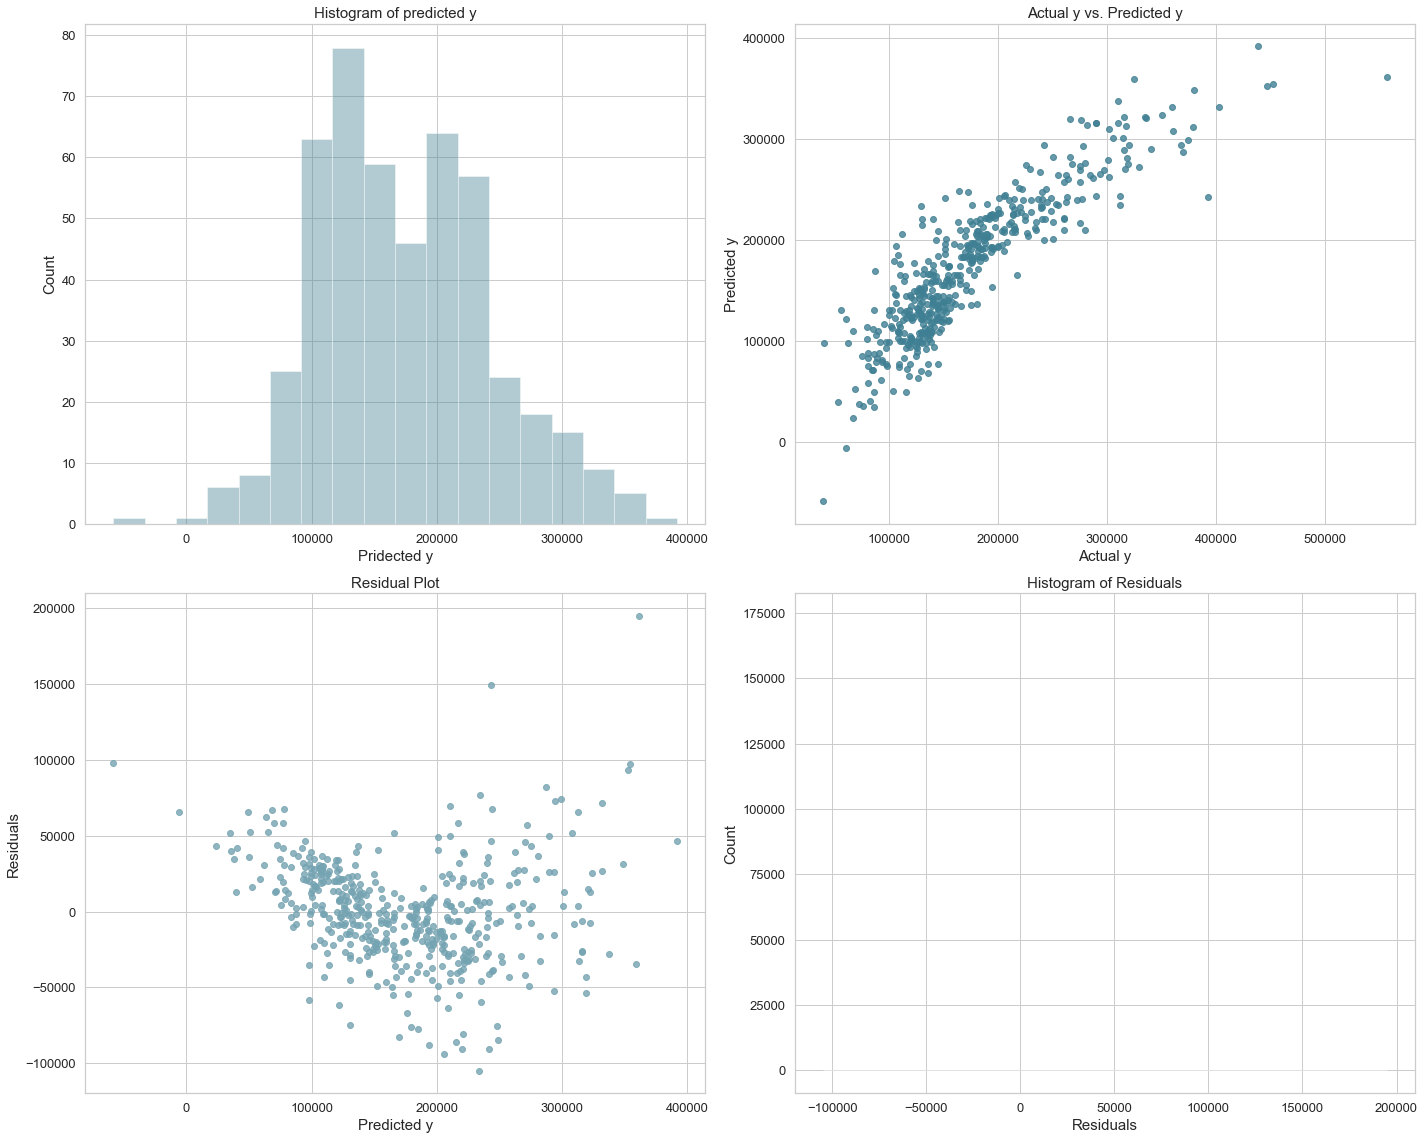

Model: Linear
    Taking log on y
    Best Params: {}
    MSE is:  862178653.1042842
    RMSE is:  29362.878828621084


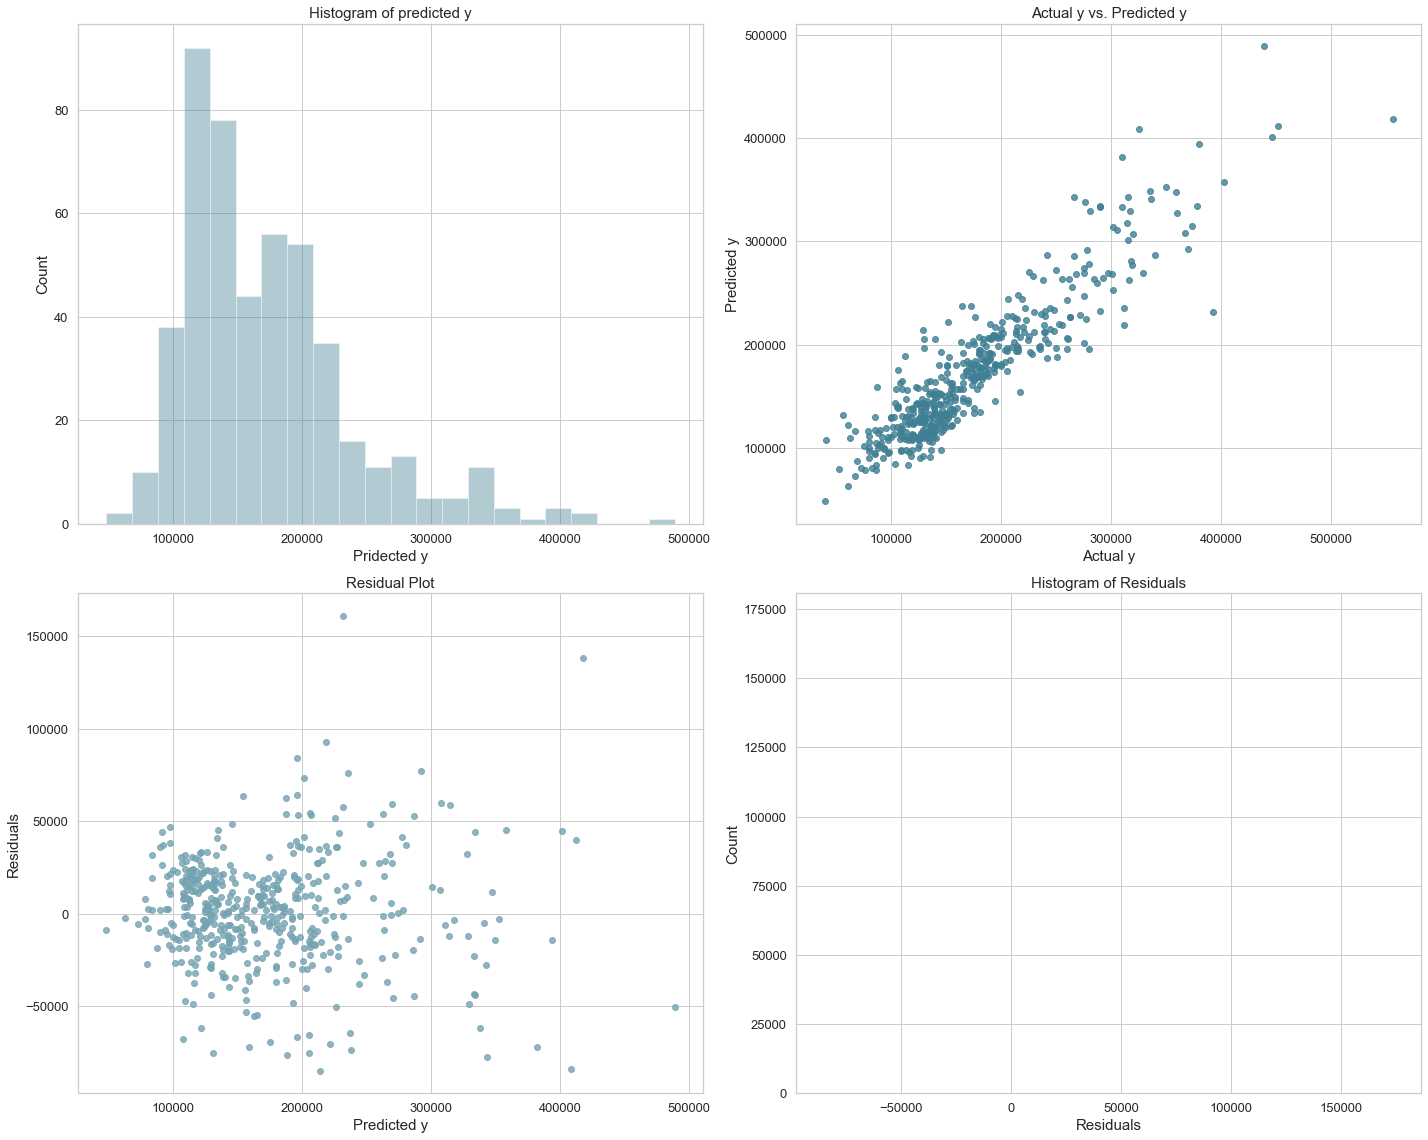

Model: Ridge
    NOT taking log on y
    Best Params: {'ridge__alpha': 10}
    MSE is:  1137685880.8021894
    RMSE is:  33729.59947586377


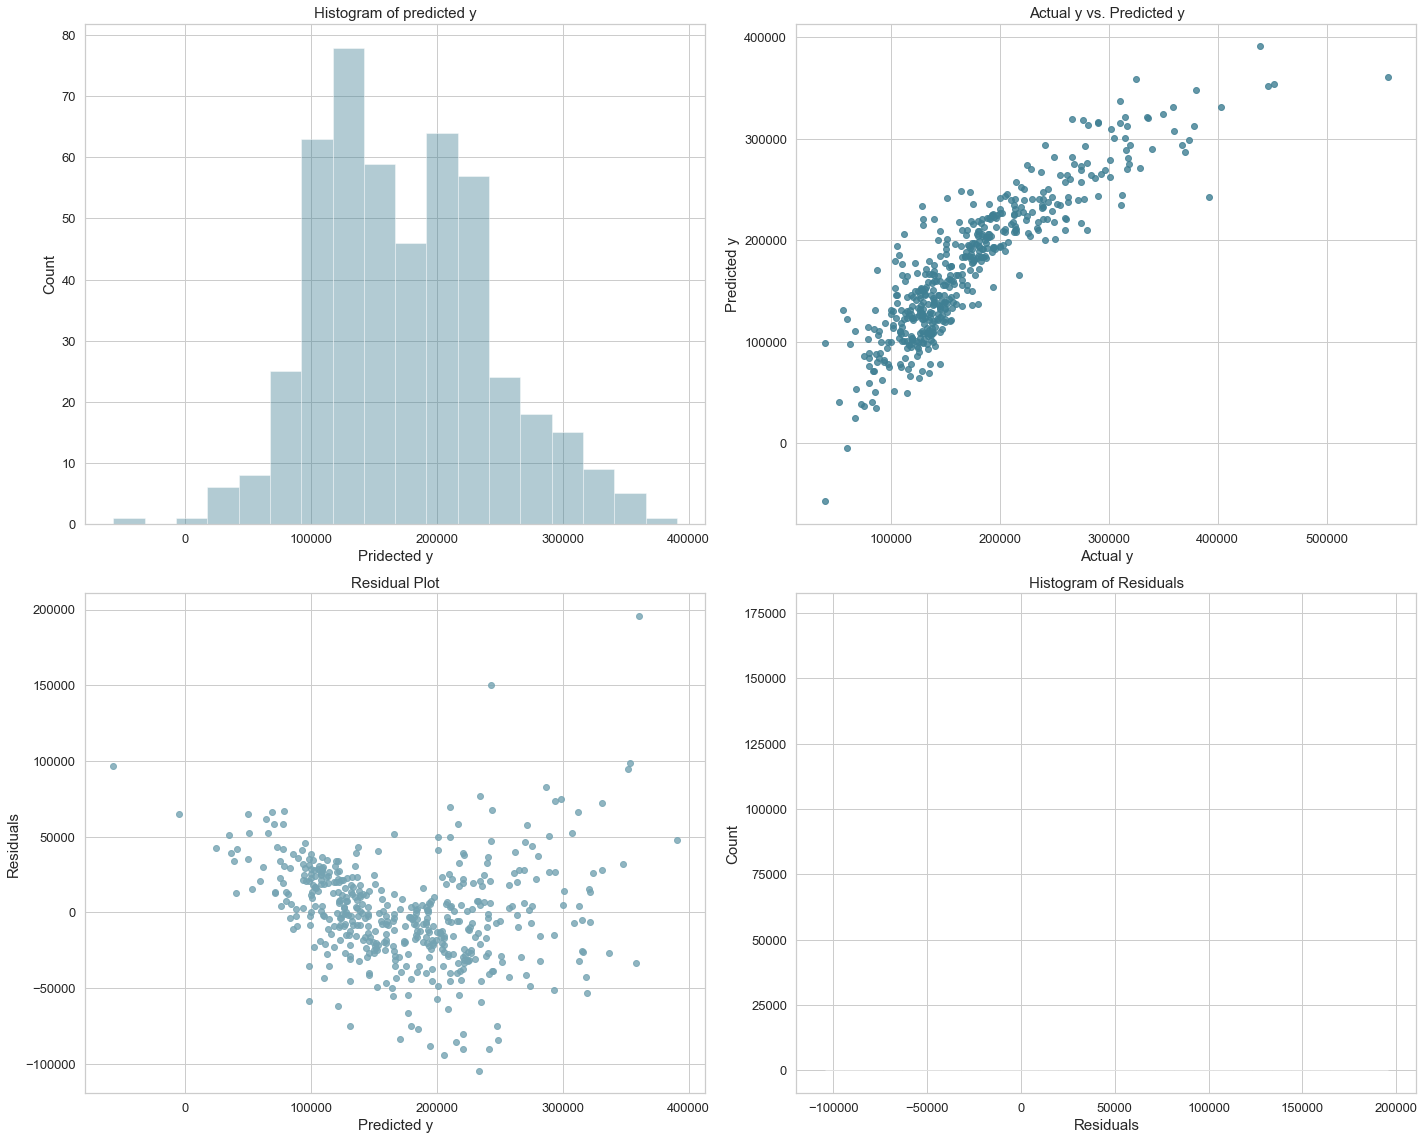

Model: Ridge
    Taking log on y
    Best Params: {'ridge__alpha': 10}
    MSE is:  863720409.8790137
    RMSE is:  29389.12060404349


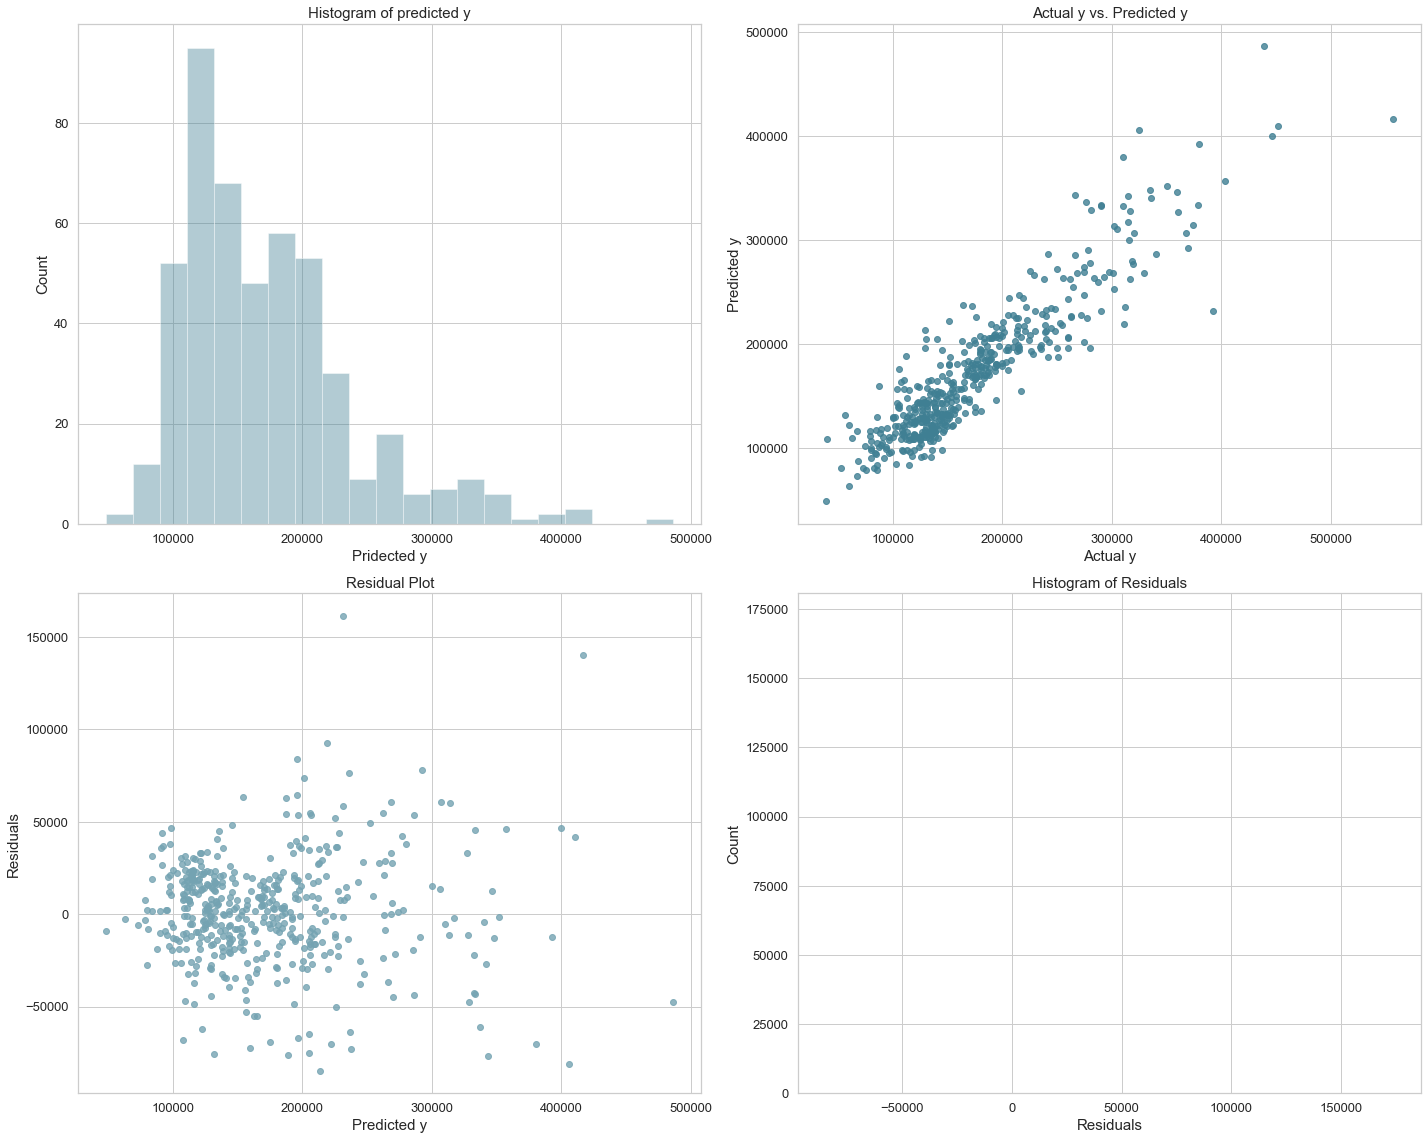

Model: Lasso
    NOT taking log on y
    Best Params: {'lasso__alpha': 100}
    MSE is:  1138475081.7962248
    RMSE is:  33741.29638582704


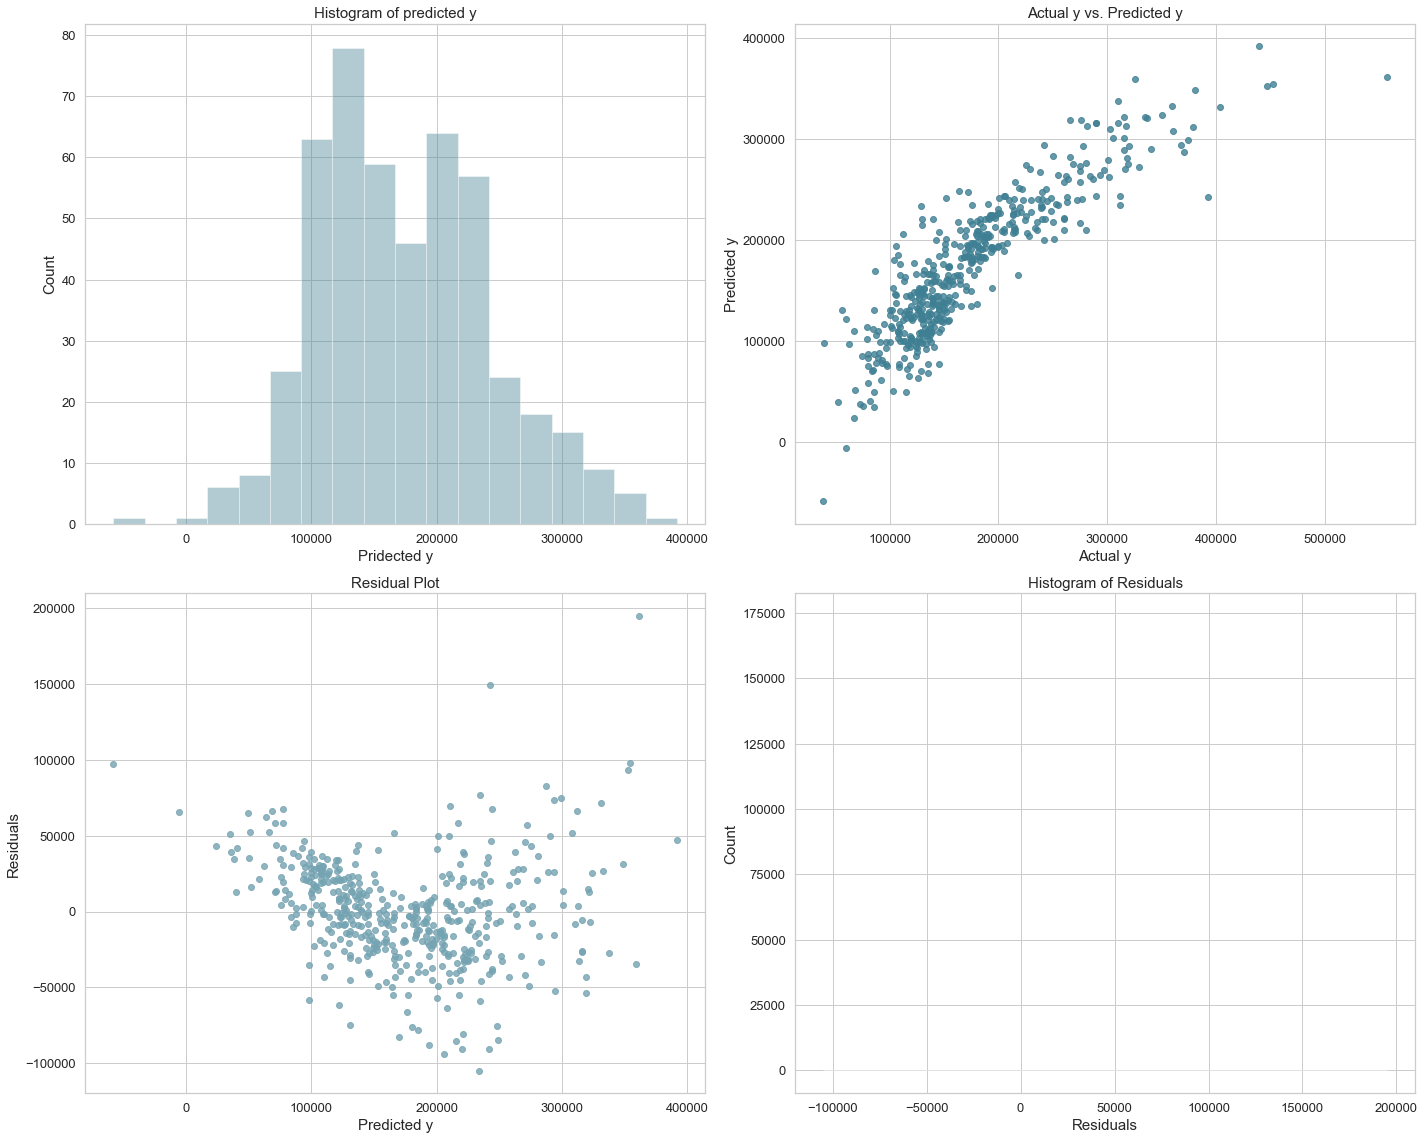

Model: Lasso
    Taking log on y
    Best Params: {'lasso__alpha': 0.0001}
    MSE is:  862191608.3619194
    RMSE is:  29363.099433845866


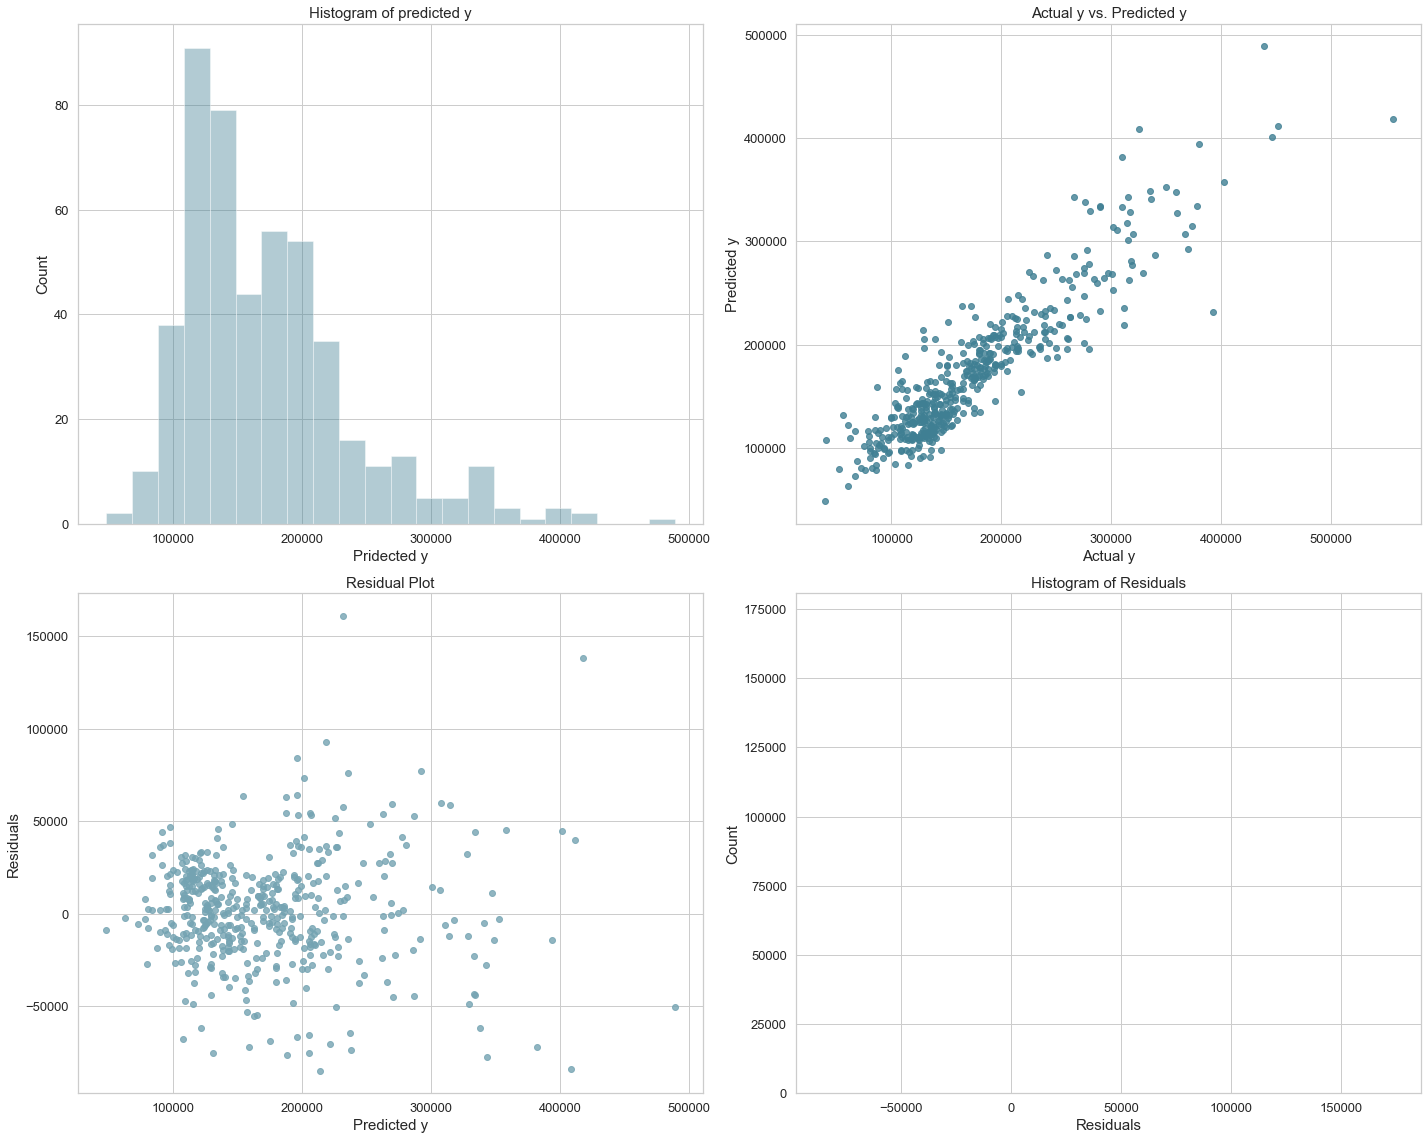

Model: RandomForest
    NOT taking log on y
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 90}
    MSE is:  943081331.2955513
    RMSE is:  30709.629292708032


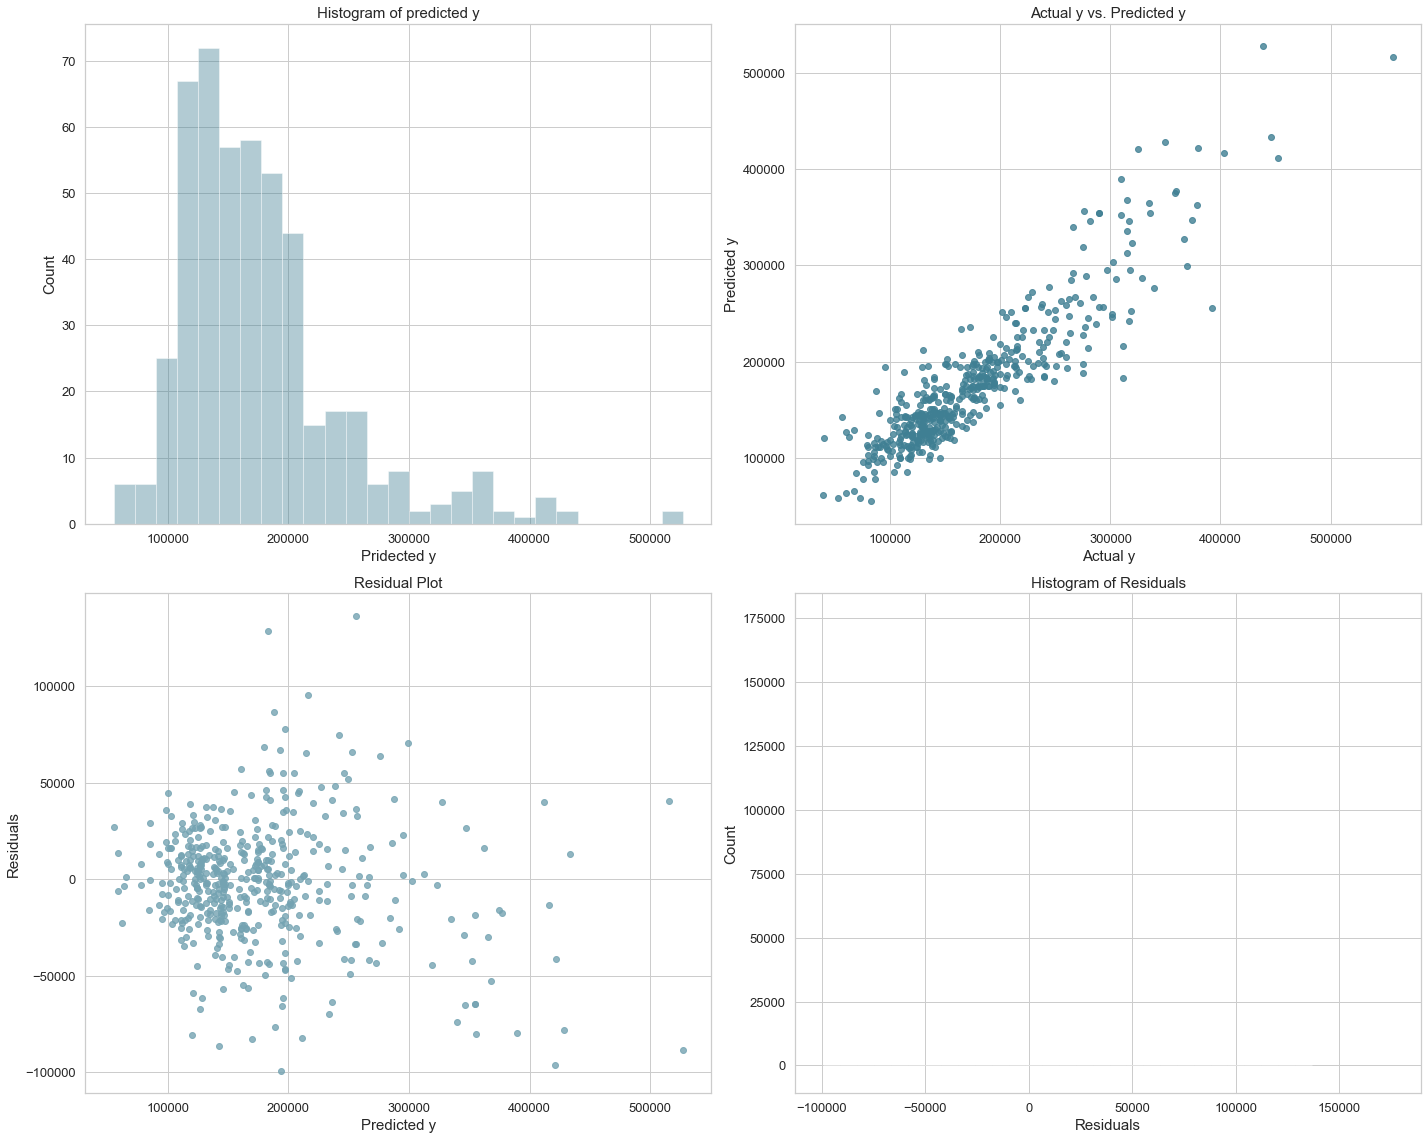

In [234]:
modelRmse = try_all_models(X, y)

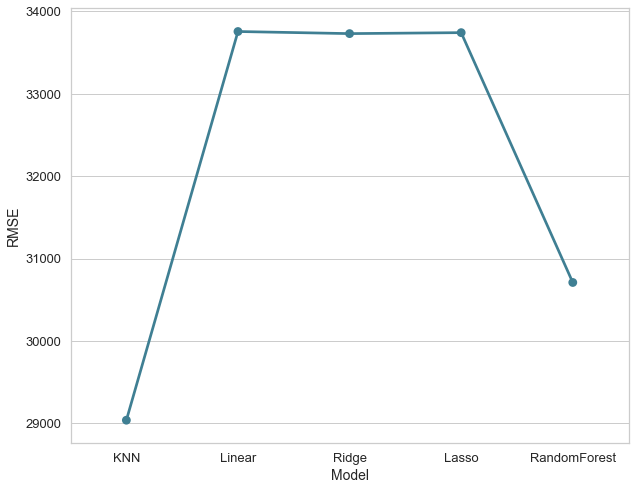

In [235]:
modelRmseDf = pd.DataFrame(list(modelRmse.items()))
modelRmseDf.columns = ['Model', 'RMSE']

fig, axes = get_sub_plots(1, 1)
sns.pointplot(x = "Model", y = "RMSE", data = modelRmseDf, ax = axes[0])
plt.show()

The initial results above showed that
1. KNN has the best RMSE.
2. Although taking log on price did make it distribute more normally, RMSE isn't better. Let's plot influence plot using statsmodel to investigate further:

In [236]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

m = ols('SalePrice ~ OverallQual + GrLivArea + GarageCars', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1555.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:17:46   Log-Likelihood:                -17371.
No. Observations:                1454   AIC:                         3.475e+04
Df Residuals:                    1450   BIC:                         3.477e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.001e+05   4526.029    -22.127      

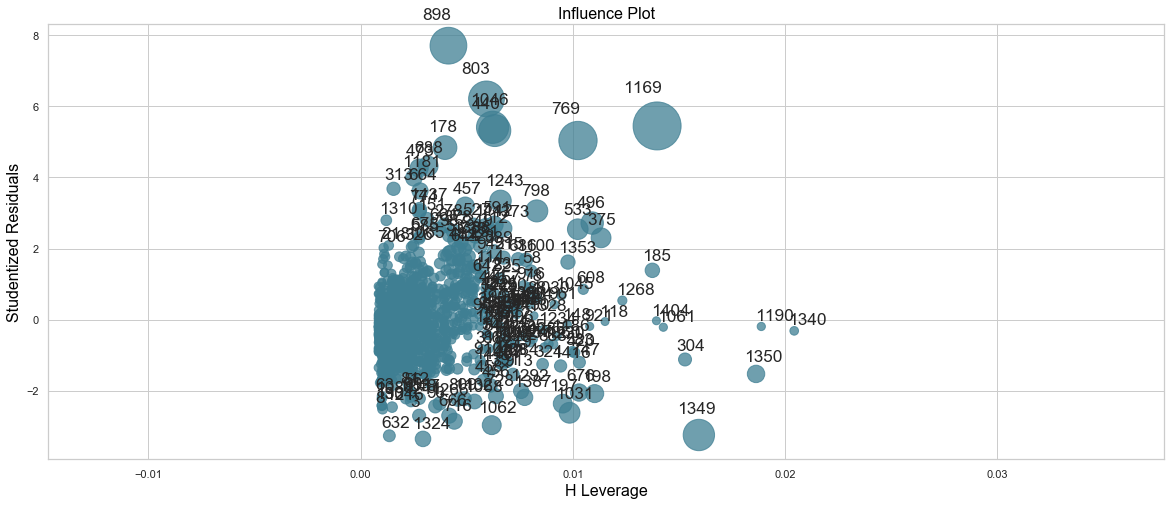

In [237]:
from statsmodels.graphics.regressionplots import influence_plot

fig, ax = plt.subplots(figsize = (20,8))
fig = sm.graphics.influence_plot(m, ax = ax, criterion = "cooks")

Remove high leverage points:

In [238]:
df = df.drop(df.index[[1298, 523, 635, 1182, 1173, 691]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1459
Data columns (total 84 columns):
Id                1448 non-null int64
MSSubClass        1448 non-null int64
MSZoning          1448 non-null object
LotFrontage       1190 non-null float64
LotArea           1448 non-null int64
Street            1448 non-null object
Alley             89 non-null object
LotShape          1448 non-null object
LandContour       1448 non-null object
Utilities         1448 non-null object
LotConfig         1448 non-null object
LandSlope         1448 non-null object
Neighborhood      1448 non-null object
Condition1        1448 non-null object
Condition2        1448 non-null object
BldgType          1448 non-null object
HouseStyle        1448 non-null object
OverallQual       1448 non-null int64
OverallCond       1448 non-null int64
YearBuilt         1448 non-null int64
YearRemodAdd      1448 non-null int64
RoofStyle         1448 non-null object
RoofMatl          1448 non-null object
Exte

In [239]:
m = ols('SalePrice ~ OverallQual + GrLivArea + GarageCars', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1551.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:17:49   Log-Likelihood:                -17298.
No. Observations:                1448   AIC:                         3.460e+04
Df Residuals:                    1444   BIC:                         3.463e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       -1e+05   4526.552    -22.101      

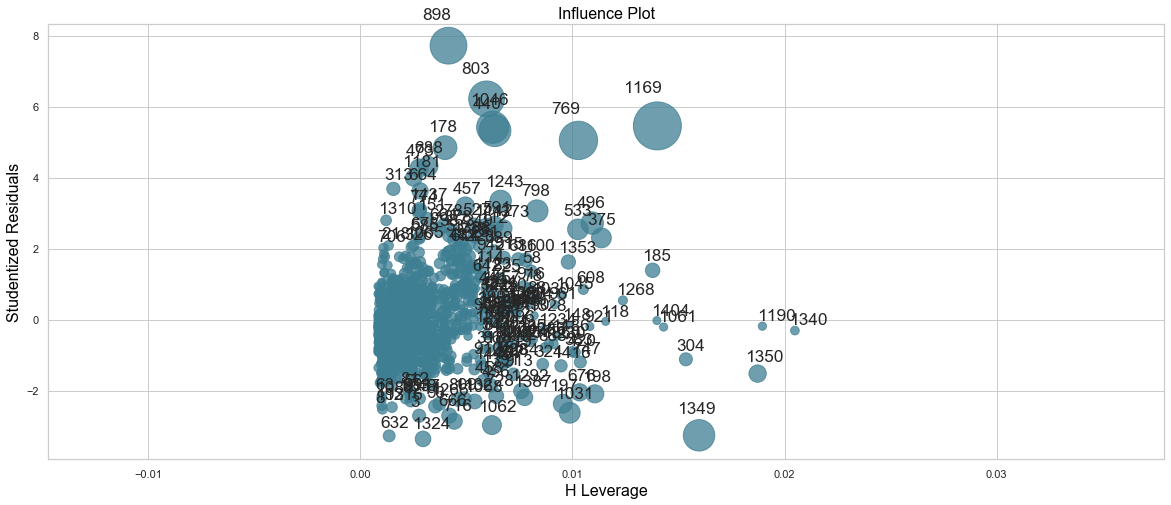

In [240]:
fig, ax = plt.subplots(figsize = (20,8))
fig = sm.graphics.influence_plot(m, ax = ax, criterion = "cooks")

High leverage points are removed. Let's train the model again:

In [241]:
X, y = get_X_y(df, ['OverallQual', 'GrLivArea', 'GarageCars'], 'SalePrice')

Model: KNN
    NOT taking log on y
    Best Params: {'knn__n_neighbors': 16}
    MSE is:  1284727556.3296776
    RMSE is:  35843.096355221285


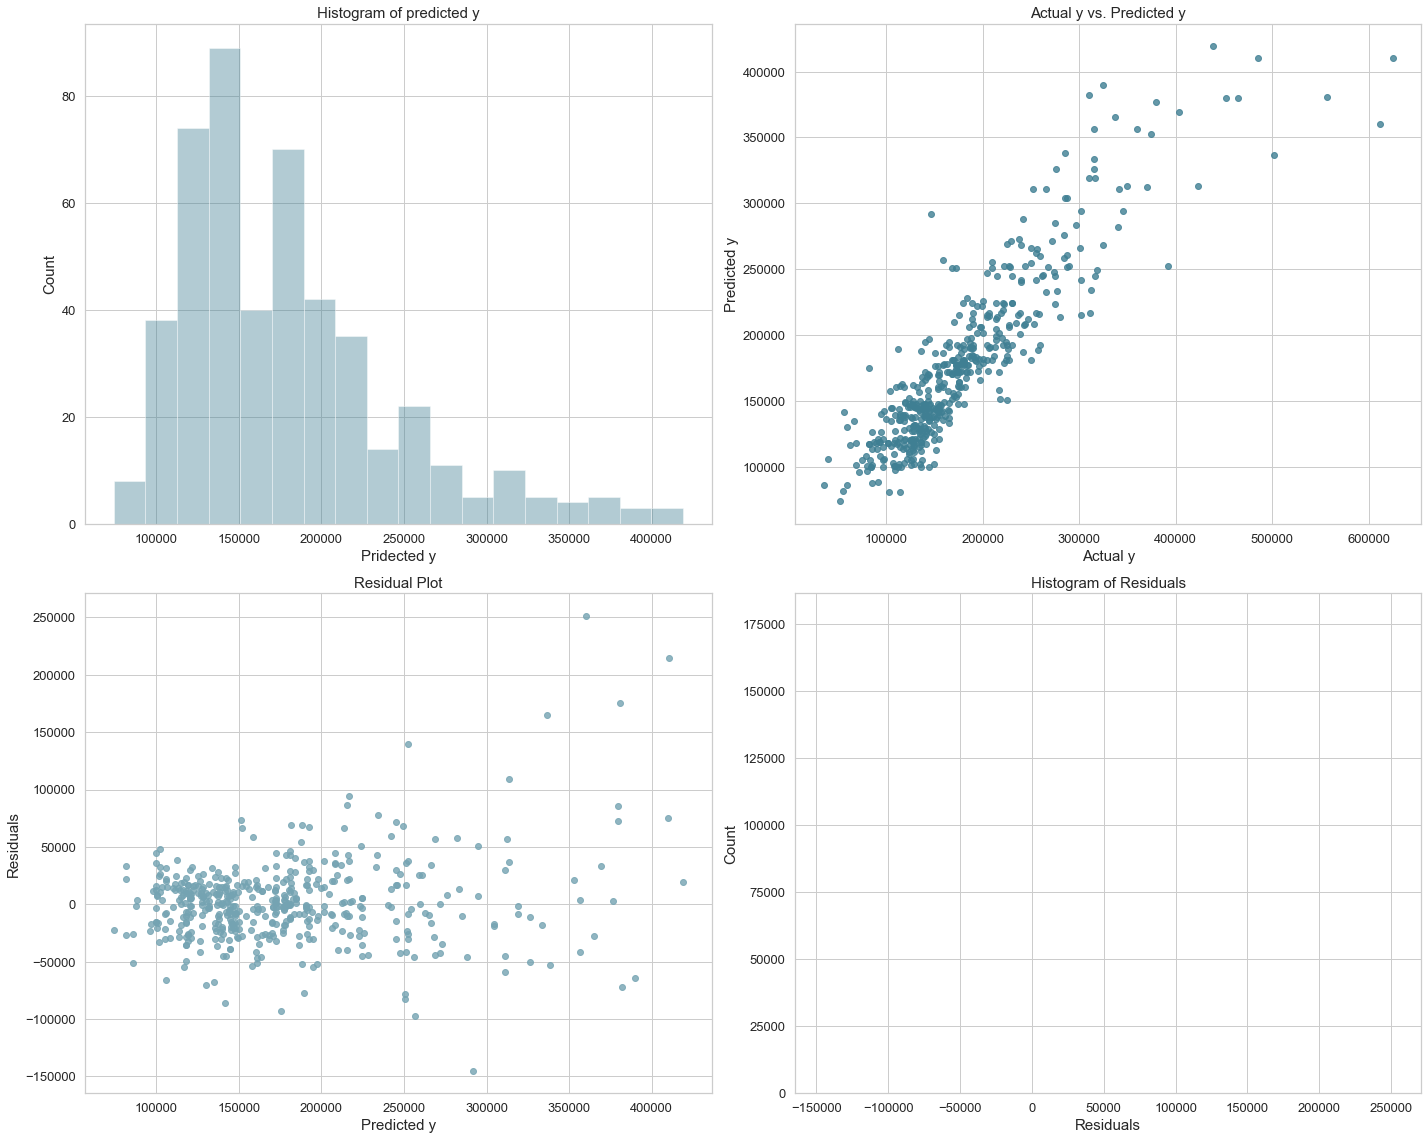

Model: Linear
    NOT taking log on y
    Best Params: {}
    MSE is:  1542028413.383302
    RMSE is:  39268.66961565291


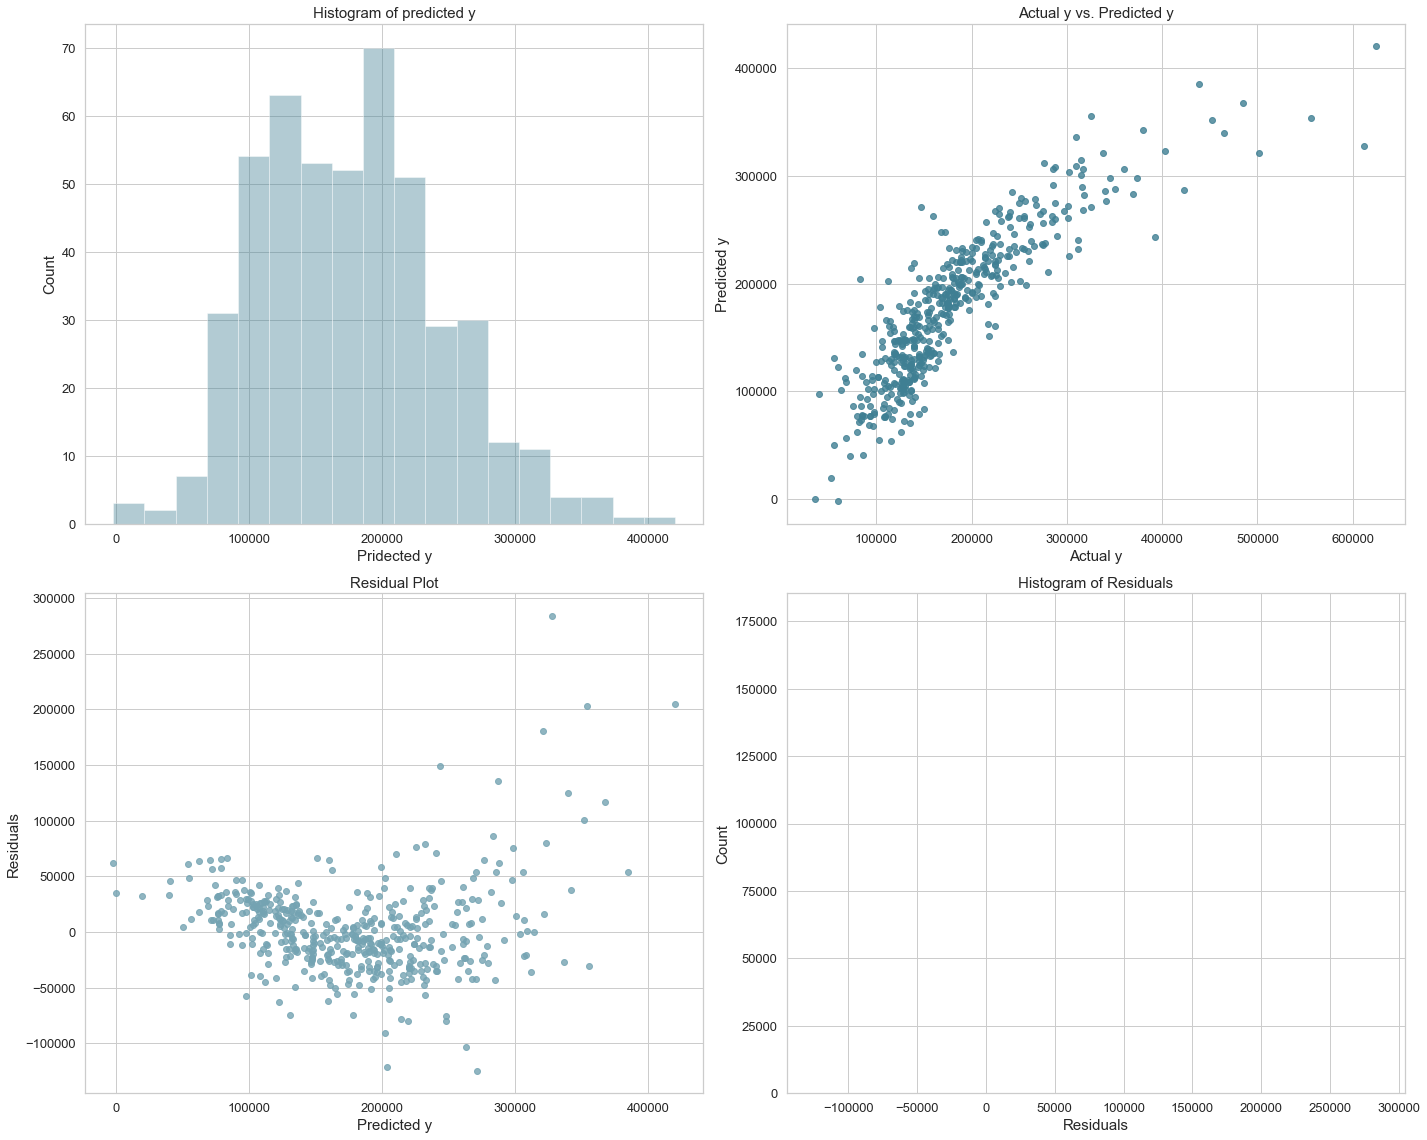

Model: Linear
    Taking log on y
    Best Params: {}
    MSE is:  1152997195.1538885
    RMSE is:  33955.81239131069


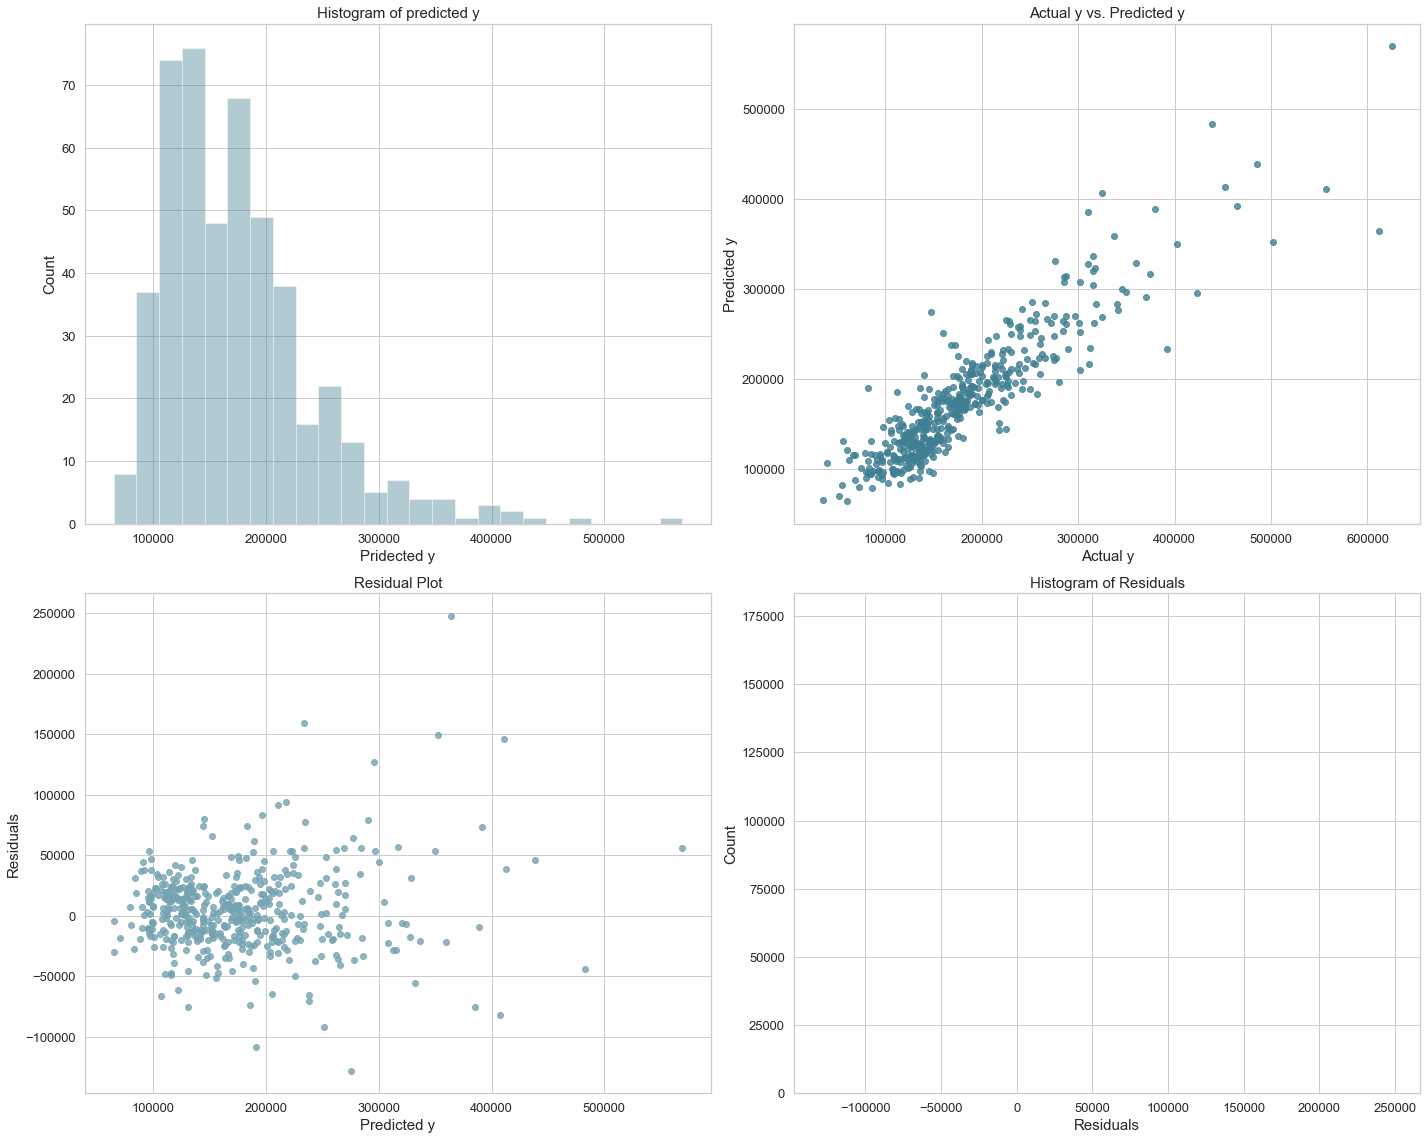

Model: Ridge
    NOT taking log on y
    Best Params: {'ridge__alpha': 10}
    MSE is:  1543127140.1664119
    RMSE is:  39282.6569896489


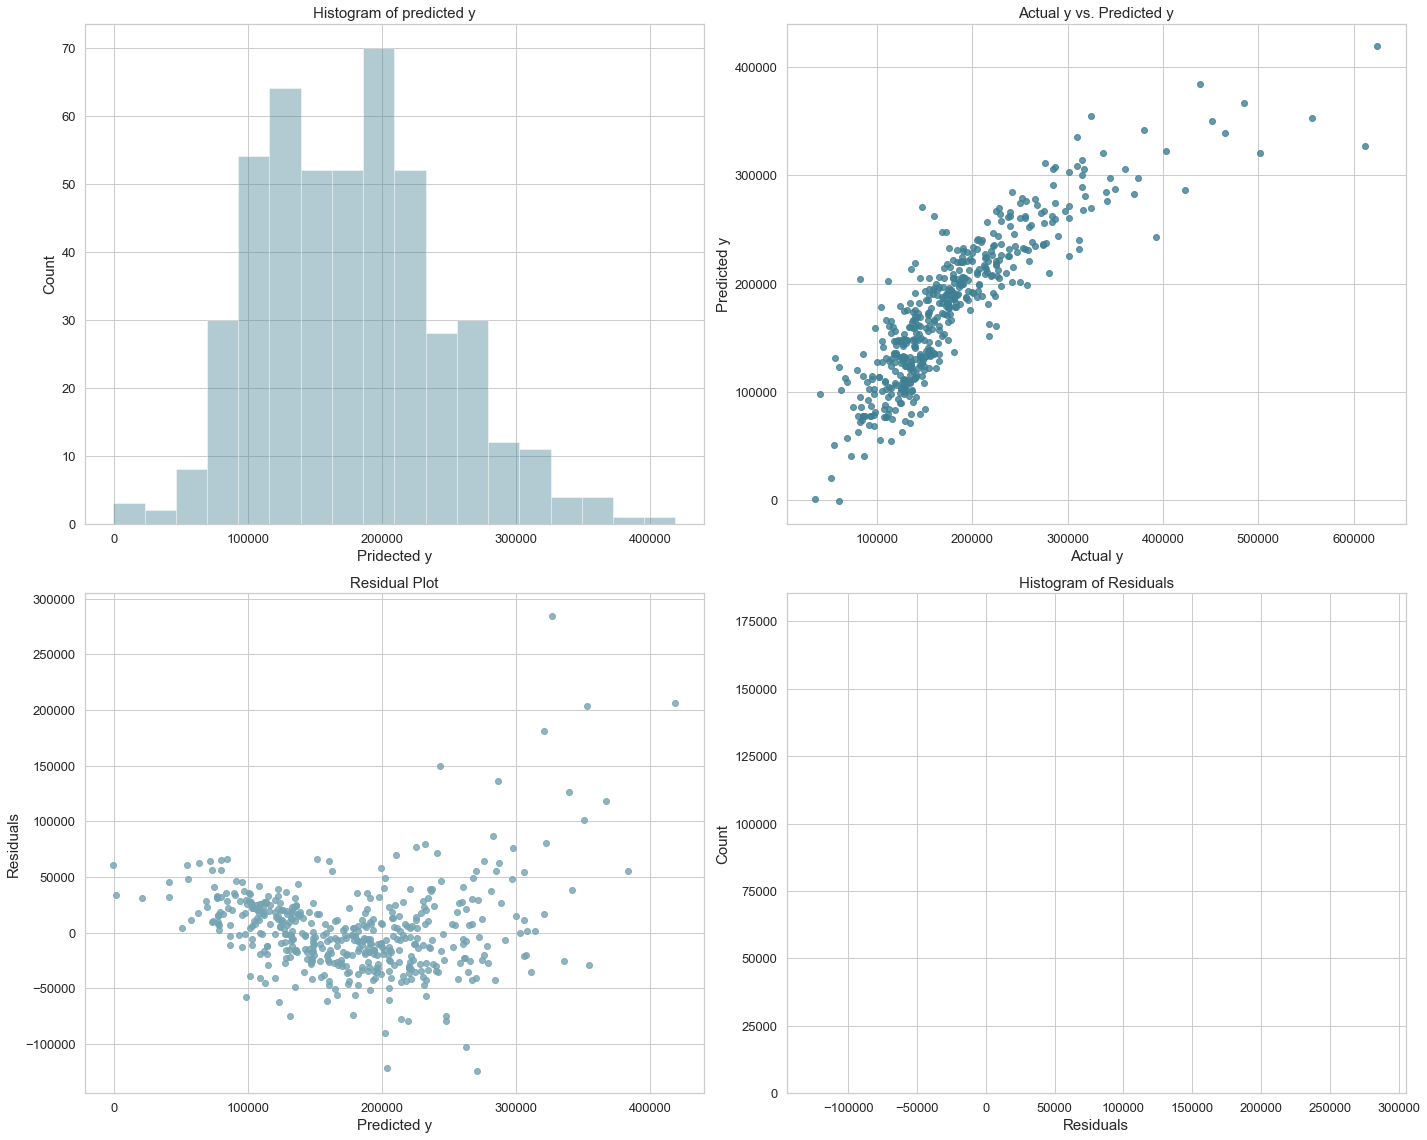

Model: Ridge
    Taking log on y
    Best Params: {'ridge__alpha': 1}
    MSE is:  1153461661.7006145
    RMSE is:  33962.65098163885


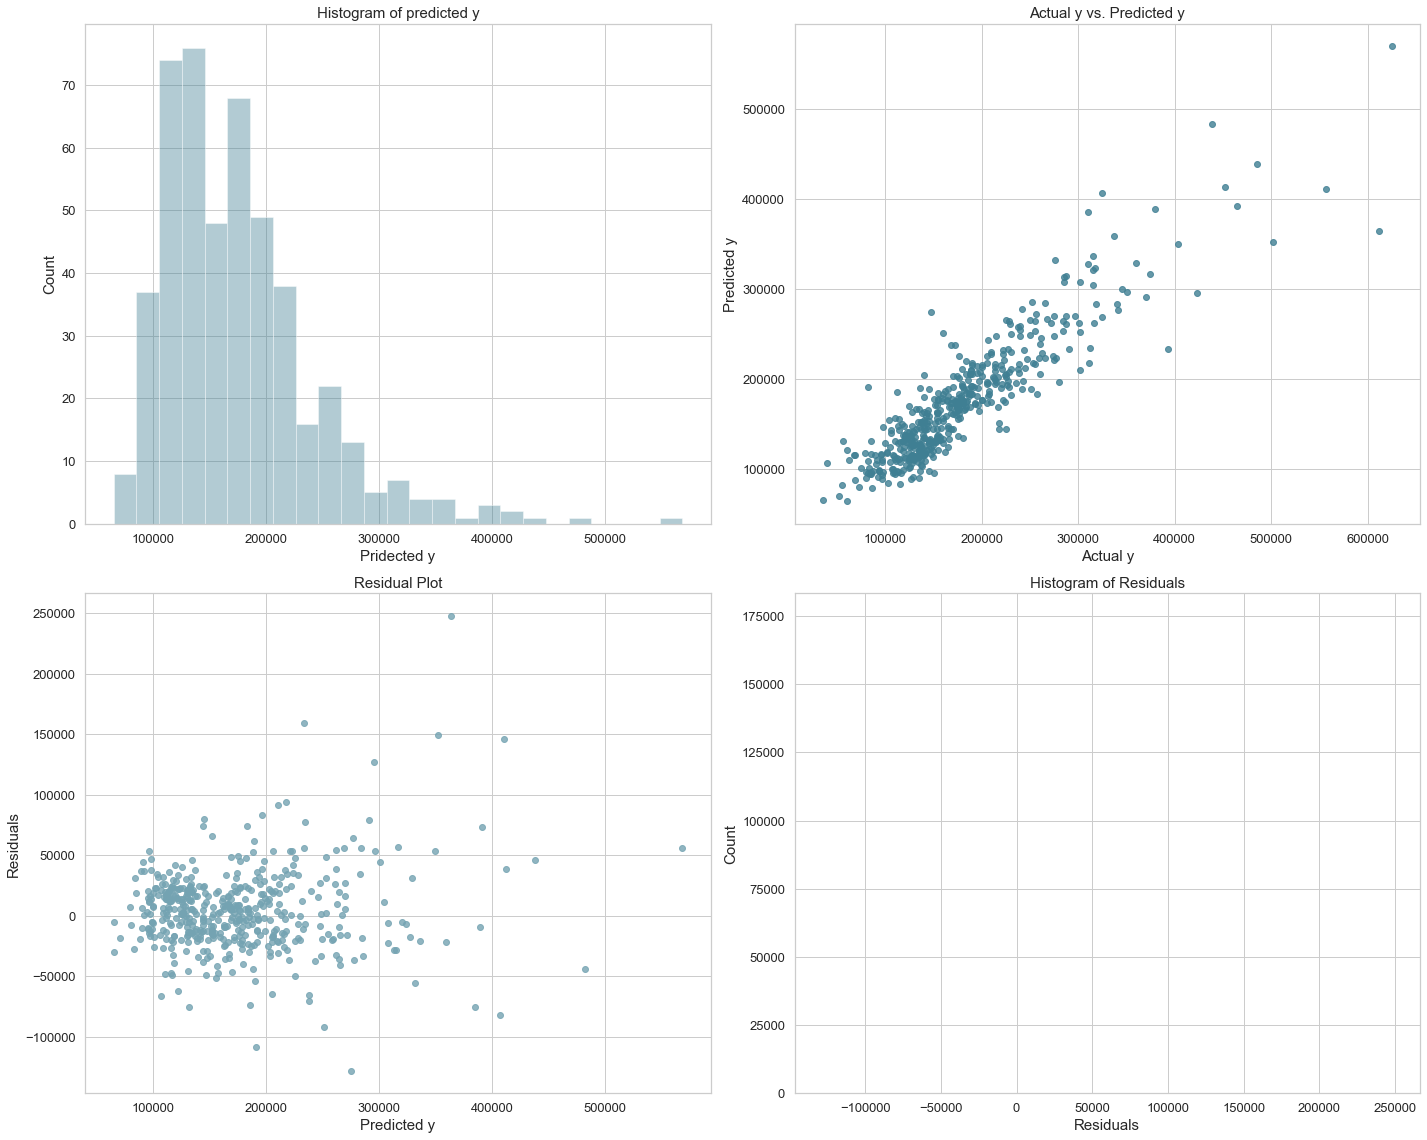

Model: Lasso
    NOT taking log on y
    Best Params: {'lasso__alpha': 100}
    MSE is:  1541682552.2192204
    RMSE is:  39264.26558869044


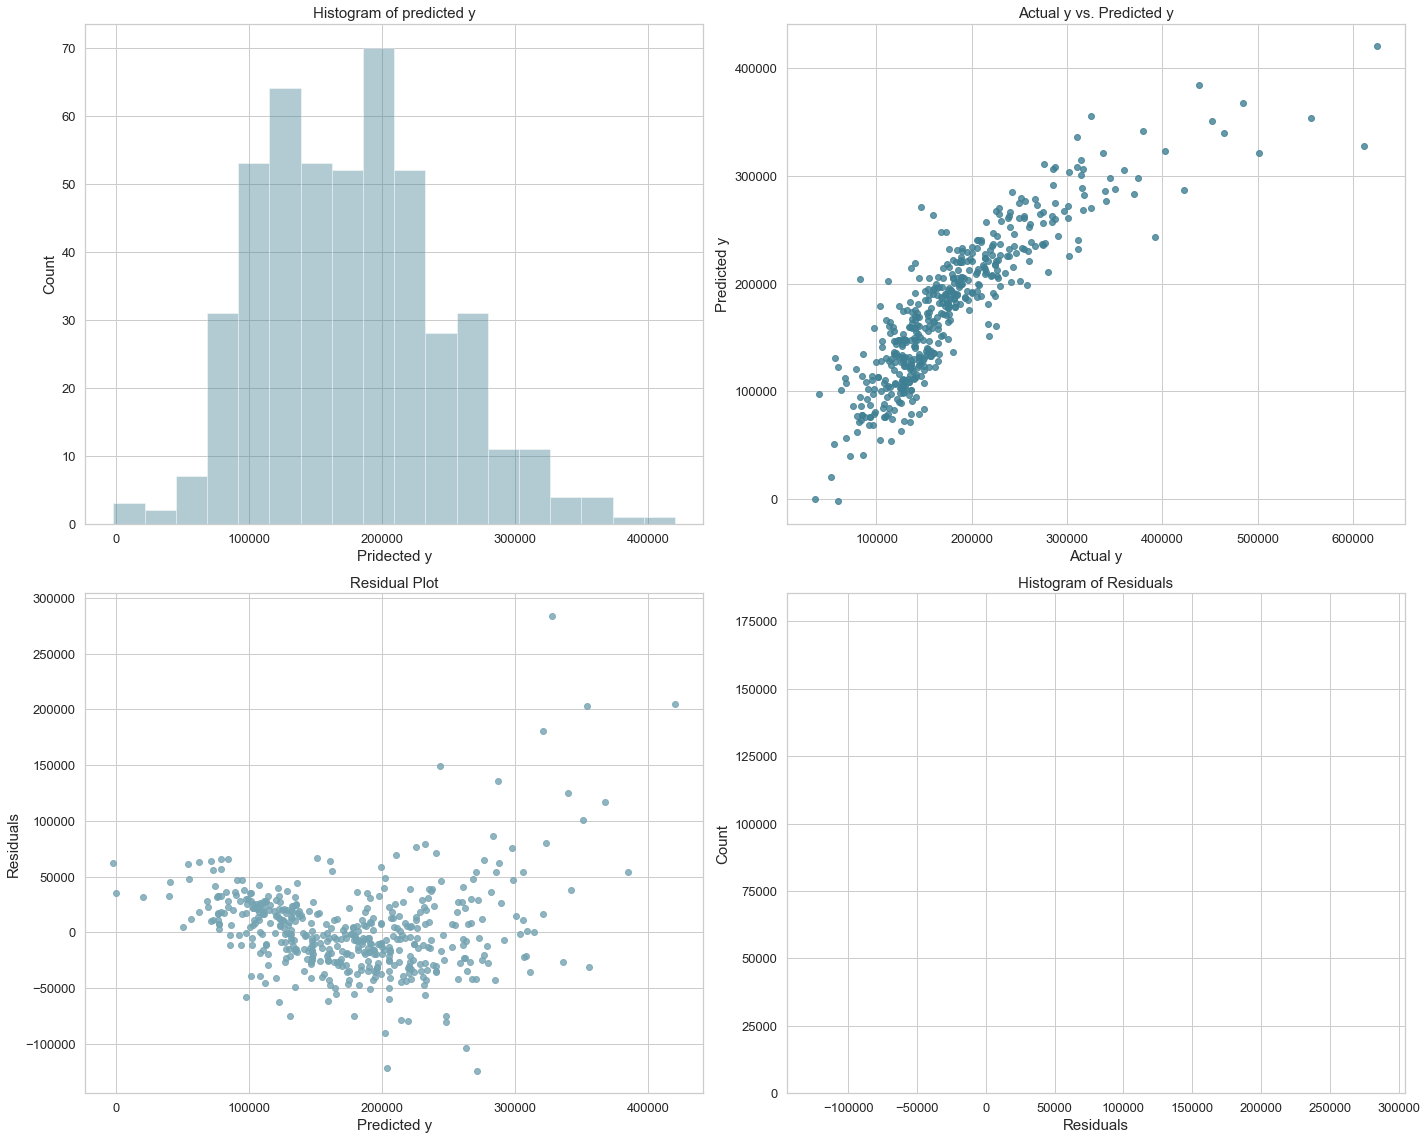

Model: Lasso
    Taking log on y
    Best Params: {'lasso__alpha': 0.0001}
    MSE is:  1153110392.4465892
    RMSE is:  33957.47918274543


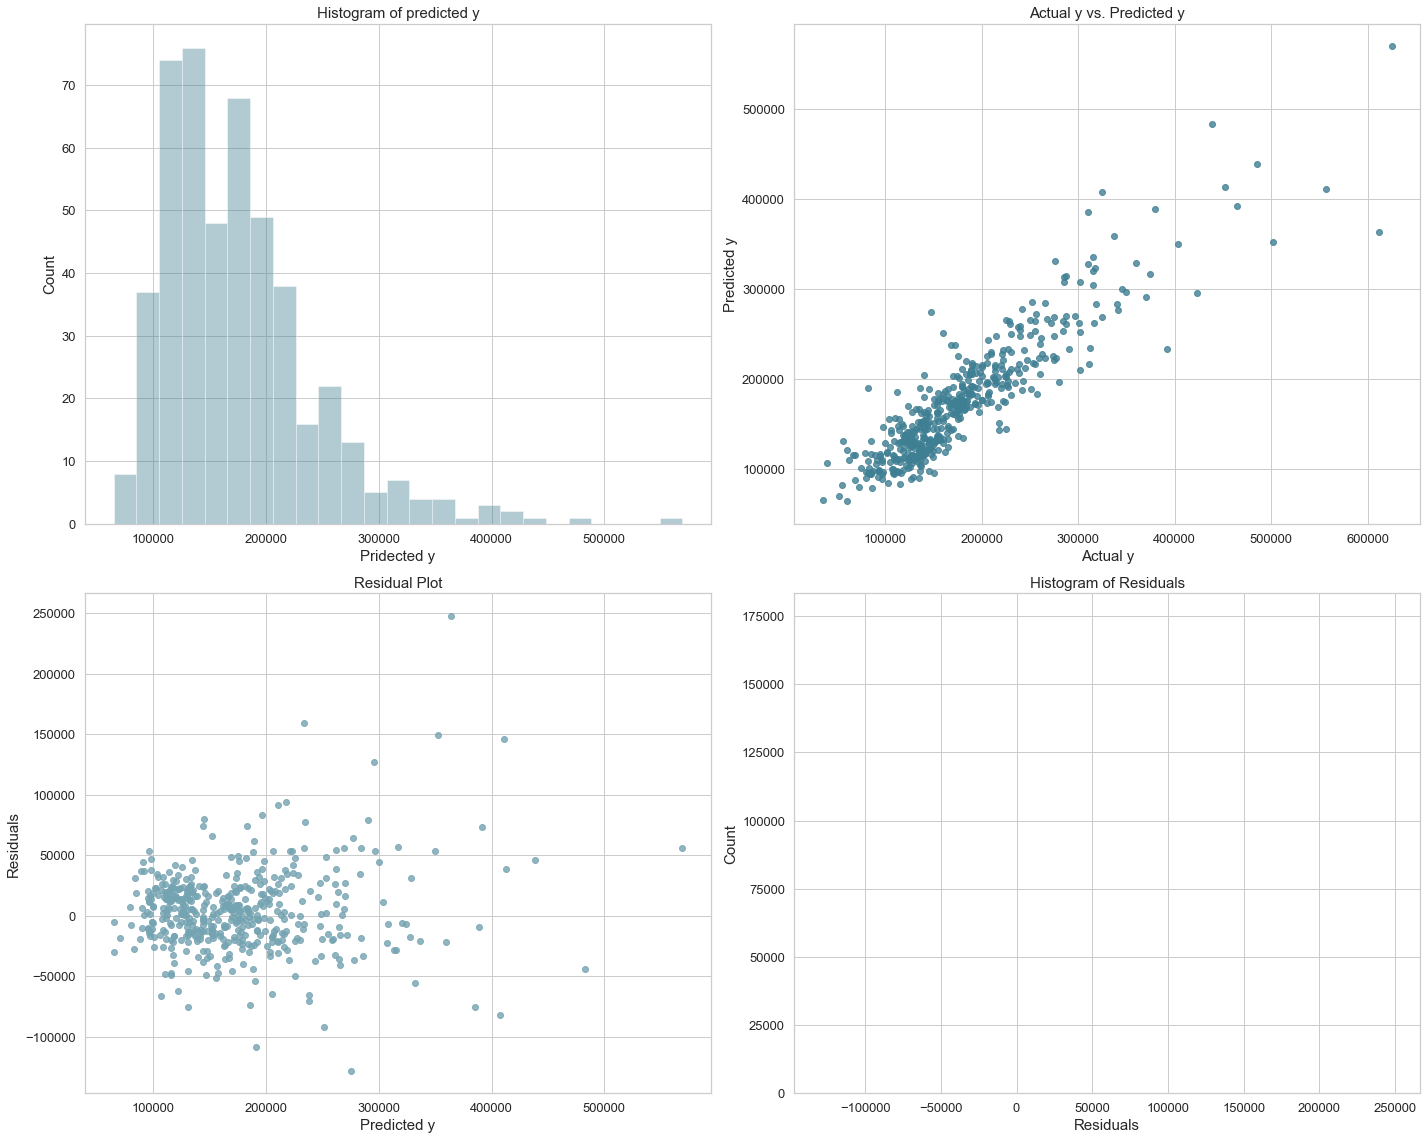

Model: RandomForest
    NOT taking log on y
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 80}
    MSE is:  1344858753.8623145
    RMSE is:  36672.315905357194


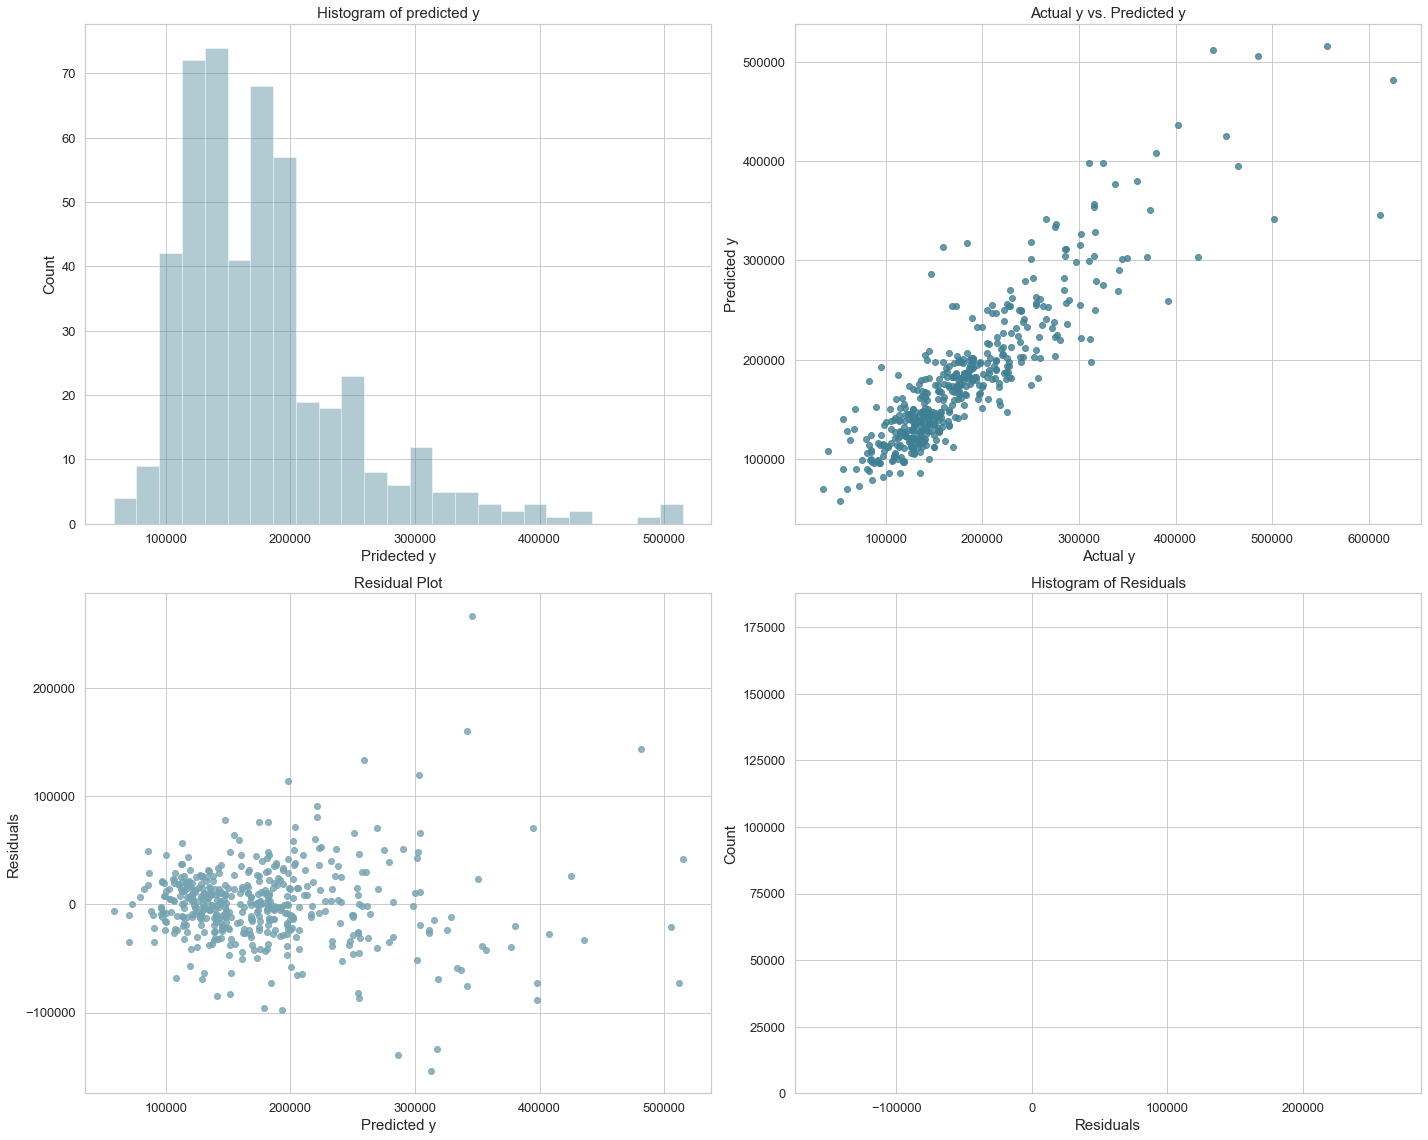

{'KNN': 35843.096355221285,
 'Linear': 39268.66961565291,
 'Ridge': 39282.6569896489,
 'Lasso': 39264.26558869044,
 'RandomForest': 36672.315905357194}

In [242]:
try_all_models(X, y)

Still RSME isn't better on linear models when taking log on price.

## Gradient Boosting

Lastly, we try the popular gradient boosting model with XGBoost, which is one of the most popular gradient boosting package.

In [245]:
import xgboost as xgb

def GB(X, y, df):
    steps = [('scaler', StandardScaler())]
    steps += [('gb', xgb.XGBRegressor(objective = 'reg:squarederror', seed = 123))]
    
    param_grid = {'gb__n_estimators': np.arange(1, 50)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model: Gradient Boosting')
    print('    Best Params:', cv.best_params_)

    y_pred_gb = cv.predict(X_test)
    score_and_plot(y_test, y_pred_gb)

    df['price_pred_gb'] = cv.predict(X)
    
    return (y_test, y_pred_gb)

Model: Gradient Boosting
    Best Params: {'gb__n_estimators': 46}
    MSE is:  1143729431.0581803
    RMSE is:  33819.0690448182


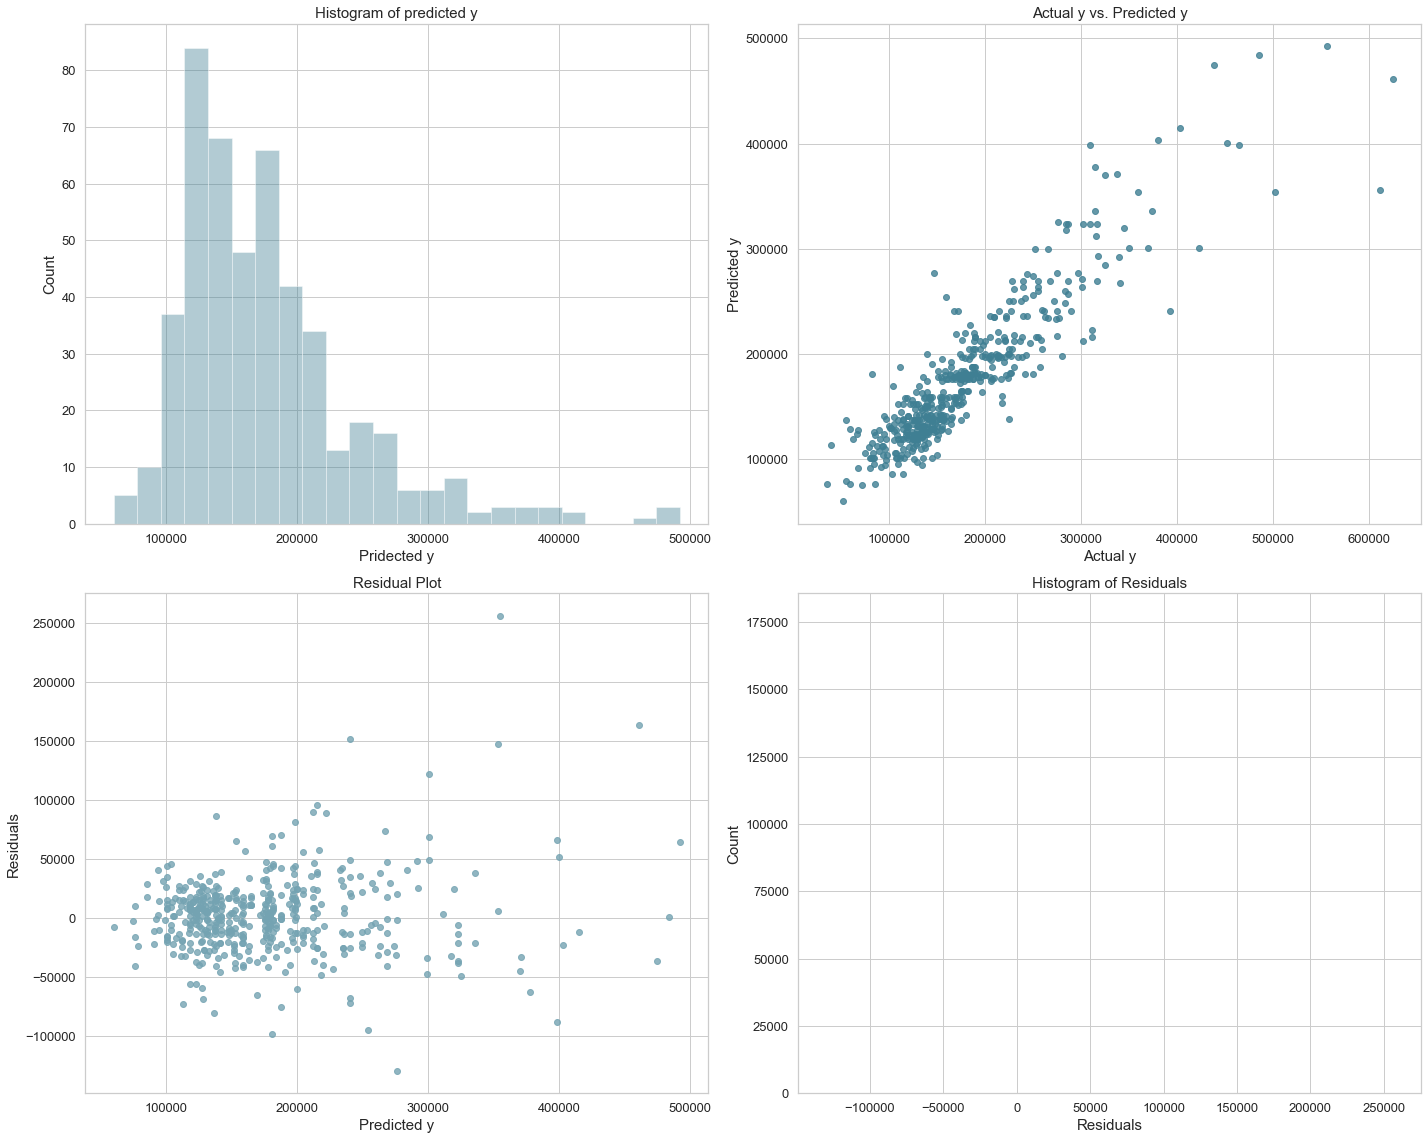

In [246]:
y_test, y_pred_knn = GB(X, y, df)

Note that previously best RMSE is 35843.096355221285, based on KNN. So gradient boosting now gives even better results than KNN which is 33819.0690448182.

## Conclusion
1. We tried 6 different models on House price prediction
    
    * K-Nearest Neighbors
    
    * Linear Regression
    
    * Ridge Regression
    
    * Lasso Regression
    
    * Random Forest
    
    * Gradient Boosting
    

2. Gradient boosting model gives the best RMSE compared to all other models.